# Classificando notícias com Redes neurais recorrentes

### Importando bibliotecas

In [1]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
# Bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import os

# Para NLP
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer

# Para deep learning e validação do modelo
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split, cross_val_score
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/giuliana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from keras.preprocessing.text import Tokenizer

### Carregando a Base

In [4]:
df = pd.read_csv('dados/bbc-text.csv', sep=',')
df_2 = df.copy()
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [5]:
df.shape

(2225, 2)

In [6]:
df['category'].nunique()

5

In [7]:
set(df['category'])

{'business', 'entertainment', 'politics', 'sport', 'tech'}

In [8]:
df.isnull().sum()

category    0
text        0
dtype: int64

## Conhecendo os dados

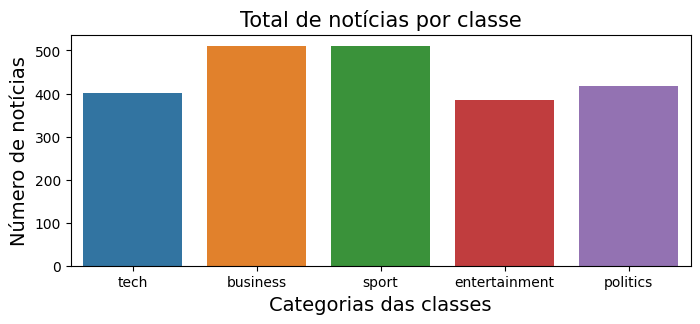

In [9]:
plt.figure(figsize=(8,3))
sns.countplot(data=df, x='category', hue='category')
plt.title("Total de notícias por classe", size=15)
plt.xlabel("Categorias das classes", size=14)
plt.ylabel("Número de notícias", size=14)
plt.show()

## Pré-processamento de texto

In [10]:
# função para a limpeza de texto 

def limpeza_texto(text):
    whitespace = re.compile(r'\s+')
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(" ", text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub("\d+", "", text)                             
    text = re.sub(r'[^\w\s]','',text)                         
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    text = [word for word in text.split() if word not in list(STOPWORDS)]
    
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))

    return ' '.join(sentence)

In [11]:
print('Texto antes da limpeza:\n', df['text'][0])
print('-_'*50)
print('Texto depois da limpeza:\n', limpeza_texto(df['text'][0]))

Texto antes da limpeza:
 tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are als

In [12]:
# aplicando a função no dataframe
df['text'] = df['text'].apply(limpeza_texto)

In [13]:
total_antigo = df_2['text'].apply(len).sum()
total_novo = df['text'].apply(len).sum()

In [14]:
# medindo o total de caracteres do dataframe 
print(f'Tamanho de caracteres do dataframe antigo: {total_antigo}')
print(f'Tamanho de caracteres do dataframe novo: {total_novo}')

Tamanho de caracteres do dataframe antigo: 5035033
Tamanho de caracteres do dataframe novo: 3280729


In [15]:
# medindo o total de palavras do dataframe 

antigo_palavras = df_2['text'].apply(lambda x: len([i for i in x.split()])).sum()
novo_palavras = df['text'].apply(lambda x: len([i for i in x.split()])).sum()

print(f'Total de palavras do dataframe antigo: {antigo_palavras}')
print(f'Total de palavras do dataframe novo: {novo_palavras}')
print(f'Número de palavras removidas durante a limpeza: {antigo_palavras - novo_palavras}')

Total de palavras do dataframe antigo: 868407
Total de palavras do dataframe novo: 488645
Número de palavras removidas durante a limpeza: 379762


## Tokenização e vetorização

### Vetorização

In [16]:
samples = list(df['text'][:5].values)  # amostra dos primeiros 5 documentos do nosso conjunto de dados

In [17]:
print(samples)

['tv future hand viewers home theatre systems plasma highdefinition tvs digital video recorders move live room way people watch tv will radically different five years time accord expert panel gather annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes us lead trend program content will deliver viewers via home network cable satellite telecoms company broadband service providers front room portable devices one talkedabout technologies ces digital personal video recorders dvr pvr settop box us s tivo uk s sky system allow people record store play pause forward wind tv program want essentially technology allow much personalise tv builtin highdefinition tv set big business japan us slower take europe lack highdefinition program people forward wind advert forget abide network channel schedule put together alacarte entertainment us network cable satellite company worry mean term advertise revenues well brand identity viewer loyalty channel al

In [18]:
token_index = {} # cria um indice vazio 

for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # atribuindo índice exclusivo para cada palavra única
            
max_length = 15 # define um valor max para o comprimento das sequencias

# armazena os resultados em um array multidimensional de zeros
# essa matriz será usada para armazenar a codificação one-hot das palavras em cada sequencia de amostra
results = np.zeros(shape=(len(samples),
                          max_length,
                          max(token_index.values())+1))

print("Shape de resultados armazenados:", results.shape)
print("Índice de token de palavras únicas\n", token_index)

# criando a matriz one hot encoding 
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index] = 1

Shape de resultados armazenados: (5, 15, 680)
Índice de token de palavras únicas
 {'tv': 1, 'future': 2, 'hand': 3, 'viewers': 4, 'home': 5, 'theatre': 6, 'systems': 7, 'plasma': 8, 'highdefinition': 9, 'tvs': 10, 'digital': 11, 'video': 12, 'recorders': 13, 'move': 14, 'live': 15, 'room': 16, 'way': 17, 'people': 18, 'watch': 19, 'will': 20, 'radically': 21, 'different': 22, 'five': 23, 'years': 24, 'time': 25, 'accord': 26, 'expert': 27, 'panel': 28, 'gather': 29, 'annual': 30, 'consumer': 31, 'electronics': 32, 'show': 33, 'las': 34, 'vegas': 35, 'discuss': 36, 'new': 37, 'technologies': 38, 'impact': 39, 'one': 40, 'favourite': 41, 'pastimes': 42, 'us': 43, 'lead': 44, 'trend': 45, 'program': 46, 'content': 47, 'deliver': 48, 'via': 49, 'network': 50, 'cable': 51, 'satellite': 52, 'telecoms': 53, 'company': 54, 'broadband': 55, 'service': 56, 'providers': 57, 'front': 58, 'portable': 59, 'devices': 60, 'talkedabout': 61, 'ces': 62, 'personal': 63, 'dvr': 64, 'pvr': 65, 'settop': 66

In [19]:
len(samples)

5

In [20]:
max_length

15

In [21]:
max(token_index.values())+1

680

In [22]:
results

array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

    

In [23]:
# aplicando LabelEncoder nas classes

X = df['text']
encoder = LabelEncoder()
y = encoder.fit_transform(df['category'])

In [24]:
# as categorias depois da transformação - primeiras 10 linhas
print(y[:10])

[4 0 3 3 1 2 2 3 3 1]


In [25]:
print("tamanho dos dados de entrada: ", X.shape)
print("tamanho da variável target: ", y.shape)

tamanho dos dados de entrada:  (2225,)
tamanho da variável target:  (2225,)


In [26]:
# separando em treino e teste 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

In [27]:
X_train

1536    rise uk jobless total uk s jobless total rise ...
19      game maker fight survival one britain s larges...
959     optimism remain uk house uk property market re...
977     jones happy henson heroics wales flyhalf steph...
129     williams battle aussie title serena williams s...
                              ...                        
1581    howard truanted play snooker conservative lead...
1407    splitcaps pay m compensation investors lose mo...
870     macy s owner buy rival bn us retail giant fede...
1249    blair damage blunkett row majority voters beli...
1793    de niro film lead us box office film star robe...
Name: text, Length: 1780, dtype: object

### Tokenização

In [28]:
# instanciamos a classe Tokenizer para a tokenizaçào e a criação de um vocabulário

tokenizer = Tokenizer(num_words=1000, # palavras mais frequentes no texto
                      oov_token='<00V>') # OOV = out of vocabulary 

#fit dos dados 
tokenizer.fit_on_texts(X_train) # construindo o índice de palavras

In [29]:
# preenchimento de dados de entrada de texto X_train

train_seq = tokenizer.texts_to_sequences(X_train) # converte strings em listas inteiras
train_padseq = pad_sequences(train_seq, maxlen=200) 
# preenche a lista de inteiros para o tensor de inteiros 2D
# maxlen define o comprimento máximo desejado para as sequências após o preenchimento (padding)

In [30]:
train_padseq

array([[  0,   0,   0, ...,   4,   1, 408],
       [638,   1,   6, ..., 303,   1, 602],
       [213,  33,   1, ..., 963,   1, 208],
       ...,
       [  0,   0,   0, ...,   1, 119,  44],
       [  2,   1,   1, ..., 631,  63,   1],
       [  0,   0,   0, ...,   1,   1,   1]], dtype=int32)

In [31]:
# agora X_test 
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=200)

In [32]:
word_index = tokenizer.word_index
max_words = 1500 
total_words = len(word_index)
maxlen = 200 
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)
print("Tamanho do índice de palavras:", total_words)

Tamanho do índice de palavras: 22671


## Word Embeddings

### Rede Neural

In [33]:
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))  
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, 
                                  activation='tanh',return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, 
                                  activation='tanh',return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 70)           1586970   
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          17280     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 128)          24704     
 onal)                                                           
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 5)                 1

In [34]:
#compilando as camadas do modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#early stopping
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy', # métrica de precisão durante o treinamento
                                             patience=3, # número de épocas que o treinamento pode continuar depois de atingir o melhor número
                                              verbose=1, # mostra mensagens de progresso
                                              mode='min') # o treinamento é interrompido quando a métrica para de diminuir 

#salva o modelo com os melhores valores encontrados durante o treinamento
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', 
                               verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# treinando o modelo
history = model.fit(train_padseq, y_train, batch_size=120, 
                    epochs=15, validation_split=0.2)

# validando o modelo
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
12/12 [==============================] - 4s 212ms/step - loss: 1.8347 - accuracy: 0.1945 - val_loss: 1.8003 - val_accuracy: 0.1713
Epoch 2/15
12/12 [==============================] - 2s 192ms/step - loss: 1.7704 - accuracy: 0.2037 - val_loss: 1.8060 - val_accuracy: 0.1657
Epoch 3/15
12/12 [==============================] - 2s 196ms/step - loss: 1.7207 - accuracy: 0.2037 - val_loss: 1.7566 - val_accuracy: 0.1657
Epoch 4/15
12/12 [==============================] - 2s 197ms/step - loss: 1.6957 - accuracy: 0.2310 - val_loss: 1.7135 - val_accuracy: 0.1770
Epoch 5/15
12/12 [==============================] - 2s 198ms/step - loss: 1.6677 - accuracy: 0.2338 - val_loss: 1.7297 - val_accuracy: 0.1685
Epoch 6/15
12/12 [==============================] - 3s 219ms/step - loss: 1.6612 - accuracy: 0.2542 - val_loss: 1.7470 - val_accuracy: 0.1713
Epoch 7/15
12/12 [==============================] - 2s 200ms/step - loss: 1.6577 - accuracy: 0.2303 - val_loss: 1.7137 - val_accuracy: 0.1798
Epoch 

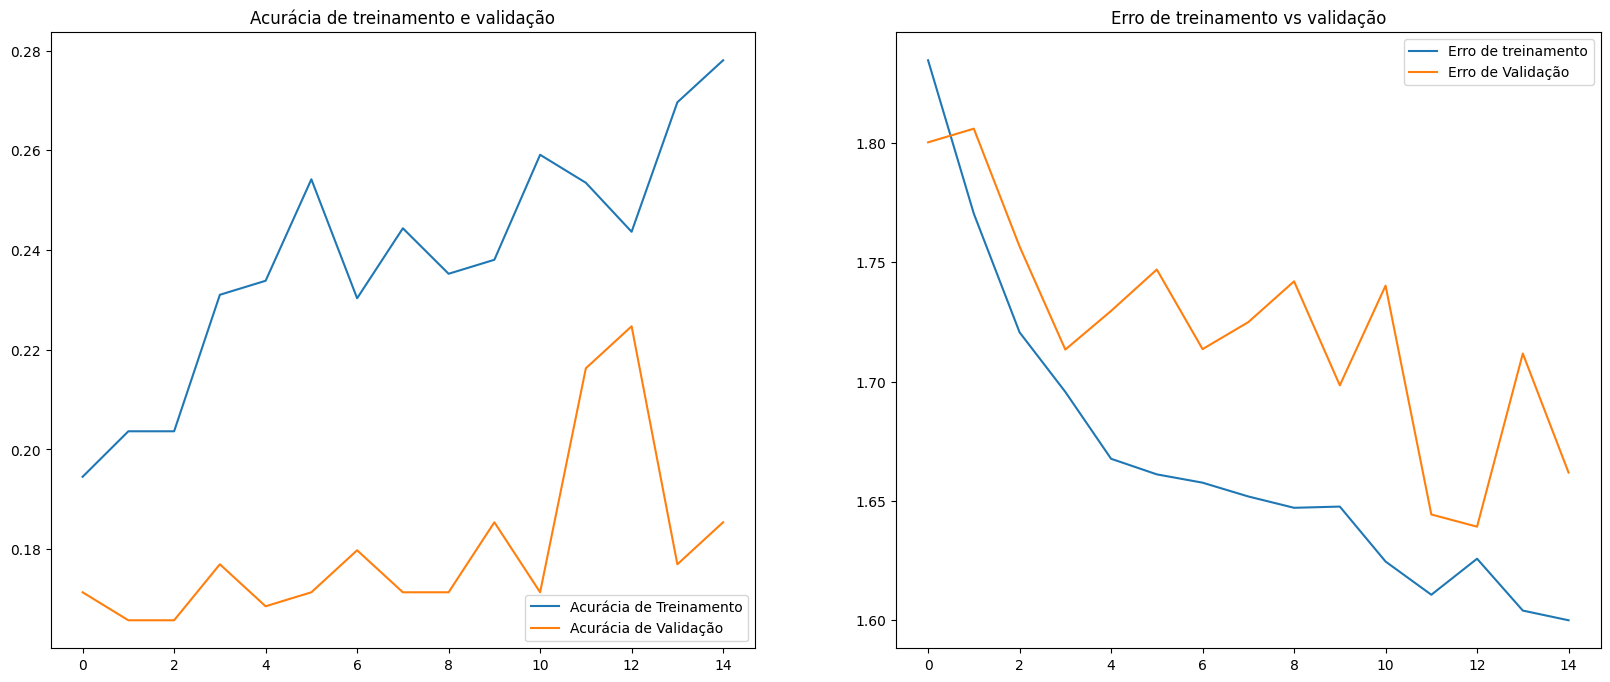

In [35]:
# visualizando resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treinamento e validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')
plt.show()

In [36]:
model.save('words_model1')

INFO:tensorflow:Assets written to: words_model1/assets


INFO:tensorflow:Assets written to: words_model1/assets


## Tunando a rede com LSTM, RNN e GRU

In [46]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
# acrescentando camadas LSTM
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
# o GRU é projetado para superar o problema do desaparecimento de gradientes nas RNNs tradicionais e é 
# especialmente eficaz em lidar com sequências de dados temporais.
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2')) 
model2.add(Dropout(0.2))
model2.add(Dense(5, activation='softmax'))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 100)          2267100   
                                                                 
 bidirectional_8 (Bidirecti  (None, 200, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 200, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_10 (Bidirect  (None, 200, 128)          24704     
 ional)                                                          
                                                                 
 conv1d_2 (Conv1D)           (None, 198, 72)           27720     
                                                      

In [47]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy', 
                                             patience=3,verbose=1, mode='min')

checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

history = model2.fit(train_padseq, y_train,
                     batch_size=120,
                     epochs=15,
                     validation_split=0.2)

test_loss, test_acc = model2.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
12/12 [==============================] - 16s 991ms/step - loss: 8.6625 - accuracy: 0.2233 - val_loss: 7.8414 - val_accuracy: 0.2360
Epoch 2/15
12/12 [==============================] - 11s 935ms/step - loss: 7.2529 - accuracy: 0.2303 - val_loss: 6.6124 - val_accuracy: 0.1629
Epoch 3/15
12/12 [==============================] - 12s 1s/step - loss: 6.0582 - accuracy: 0.2465 - val_loss: 5.4862 - val_accuracy: 0.1713
Epoch 4/15
12/12 [==============================] - 12s 1s/step - loss: 5.0617 - accuracy: 0.2535 - val_loss: 4.6274 - val_accuracy: 0.2472
Epoch 5/15
12/12 [==============================] - 11s 942ms/step - loss: 4.1731 - accuracy: 0.3181 - val_loss: 3.7368 - val_accuracy: 0.3652
Epoch 6/15
12/12 [==============================] - 12s 1s/step - loss: 3.1991 - accuracy: 0.4881 - val_loss: 2.8216 - val_accuracy: 0.5000
Epoch 7/15
12/12 [==============================] - 12s 1s/step - loss: 2.3991 - accuracy: 0.5815 - val_loss: 2.3167 - val_accuracy: 0.5618
Epoch 8/15


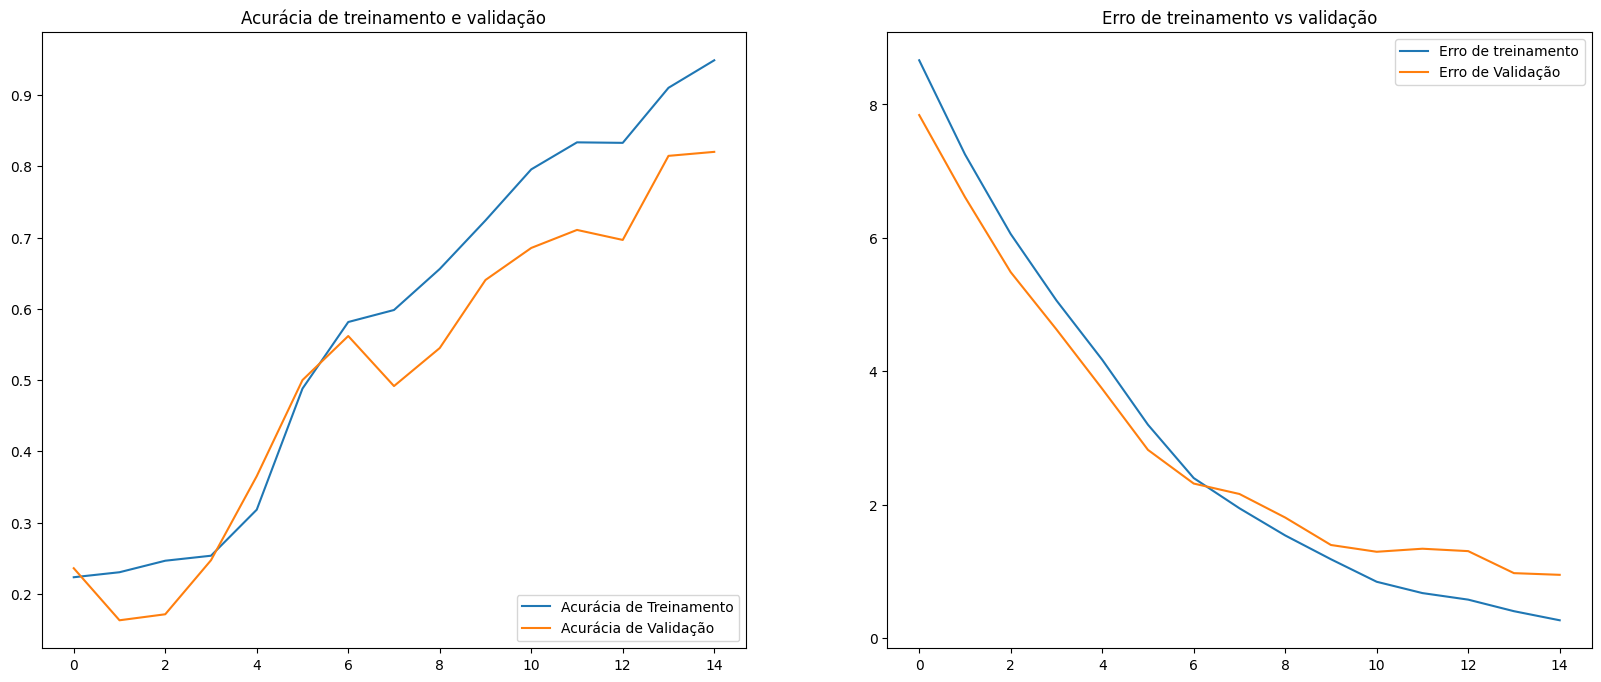

In [48]:
# resultados 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treinamento e validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')
plt.show()

In [49]:
model.save("words_model2.h5")

In [59]:
new_text = "Southgate also jettisoned Raheem Sterling last year after the Chelsea man had been a regular starter throughout most of his reign. And Jordan Henderson was left out of the 33-man preliminary squad having been a stalwart for Southgate throughout his previous three tournaments.  Grealish has been a cause celebre for England fans - who have often accused Southgate of holding an agenda against him. But he has struggled for game-time with Manchester City all season, just as Maddison has been off-form since returning from injury at Spurs.This is a bold changing of the guard from Southgate, who has relied heavily on Maguire, Henderson, Sterling and Rashford throughout his time in charge, while Grealish and Maddison are both popular flair players who fully expected to make the 26-man party for Germany."
new_text = limpeza_texto(new_text)

new_sequence = tokenizer.texts_to_sequences([new_text])
new_sequence = pad_sequences(new_sequence, maxlen=maxlen)

predictions = model2.predict(new_sequence)

class_names = ['business 0', 'entertainment 1', 'politics 2', 'sport 3', 'tech 4']

predicted_class = np.argmax(predictions)
predicted_class_name = class_names[predicted_class]

print("A frase pertence à classe:", predicted_class_name)

1/1 [==============================] - 0s 43ms/step
A frase pertence à classe: sport 3
